# Urine Marking Elo rating Calculation

## Importing other Python Libraries/Modules

In [1]:
import copy
import re
import os
import sys
import string
import glob
import ast
from collections import Counter
from collections import defaultdict
import warnings

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import git
# Getting the path of the root directory so that we can import repo specific functions
git_repo_object = git.Repo('.', search_parent_directories=True)
git_repo_directory = git_repo_object.working_tree_dir

In [4]:
# Setting path so that we can import functions
sys.path.append(os.path.join(git_repo_directory, "src"))

In [5]:
os.path.join(git_repo_directory, "src")


'/nancy/projects/dominance_strain_comparison/src'

In [6]:
from elorating import calculation
from elorating import dataframe

In [7]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

# Summary

- Experiment
    - Observing competitve behavior between two mice on top of a paper that records the urine marks. Mice are categorized as winner and loser based on the number of urine marks.
- Data
    - Excel spreadsheet of recorded tube test results. The relevant columns are those of the "Date" of the recording, the "winner" of the interaction, and the "loser" of the interaction. Each row will be for one interaction between two mice.
    - There is a cage for each sheet of the spreadsheet
    - For each recording session, we will assume that the date will be specified for that first row. We will use this to seperate all the rows into seperate sessions.
- Purpose of this Jupyter Notebook
    - To calculate the Elo Score of each mice after each interaction. The mice start off with an Elo score of 1000. Elo scores are calculated with the formula from here: https://www.omnicalculator.com/sports/elo . Then we will plot the change of elo score across all interactions. With the number of interactions on the X-Axis and the current Elo score on the Y. There will be a line for mice.

## Name of protocol for naming

- This name will be used to name files and title plots. Please change if you are using a different protocol or adding more details
    - **NOTE**: This should be changed based on the name the protocol

In [8]:
protocol_name = "urine_marking"

In [9]:
prefix_name = "uma"

In [10]:
cohort_name = "pilot_3"

In [11]:
if not cohort_name:
    cohort_name = input("""Type out the name of the cohort you are using. 
                        Make sure that this is typed as one word with individual words separated by underscore. i.e. pilot_3""")

## Getting the file name of the raw data

- Default input folder and keyword to search the files for 
    - **NOTE**: This should not be changed unless there is a consistent change with the file naming convention

In [12]:
input_folder = os.path.join(git_repo_directory, "data")

In [13]:
# Accomodates for both capitalization of the file names
raw_data_file_keyword = 'pilot_3/*[uU]rine*'

# NOTE: If there is a set excel file used for this notebook, make the cell below into a code cell and put the path in the "" (quotation marks)

In [14]:
raw_data_file_path = "../../data/pilot_3/pilot_3_Urine_Marking_Assay_Data_with_Threshold.xlsx"

- Asking the user what the path to the recording files are, with the option of using wildcards

In [15]:
if not raw_data_file_path:
    raw_data_glob_pattern = input("""Type out the path(address) of the raw behavioral recording excel sheets.
    Remember that if you are using a relative path, it will be based off of the location of this Jupyter Notebook.

    Globbing can also be used if you want to search with a wild card(Capitalization matters). 
    i.e. './data/*Home*' will be able to find './data/Homecage_observations.xlsx'

    NOTE: If left blank, the path will automatically be guessed off of the default settings 
    """)

- By default, this will search for files that are in the `./data` folder (in the folder that this notebook is in) that have key word you specified in the file name

In [16]:
if not raw_data_file_path:
    # Using the user inputted path/pattern
    if raw_data_glob_pattern.strip():
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern.strip(), recursive=True)
        # Checking if there were any files that matched
        if not raw_data_files_list:
            raise ValueError("No files were found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))

    # Using the default pattern
    else:
        raw_data_glob_pattern = os.path.join(input_folder, raw_data_file_keyword)
        raw_data_files_list = glob.glob(raw_data_glob_pattern.strip(), recursive=True)
        # Searching for matching files with recursion
        if not raw_data_files_list:
            raise ValueError("No files were found in {} that had the keyword {} in it".format(input_folder, raw_data_file_keyword))


- Checking to see if only one file is specified

In [17]:
if not raw_data_file_path:
    if len(raw_data_files_list) >= 2:
        raise ValueError("More than one file was found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))
    else:
        # Using the first(and only file) as the file path
        raw_data_file_path = raw_data_files_list[0]

In [18]:
raw_data_file_path

'../../data/pilot_3/pilot_3_Urine_Marking_Assay_Data_with_Threshold.xlsx'

## Getting a list of all the sheets

In [19]:
# Getting the sheet names for the excel file
xls = pd.ExcelFile(raw_data_file_path)
raw_data_sheet_names = xls.sheet_names

In [20]:
raw_data_sheet_names

['CAGE1', 'CAGE2', 'CAGE3', 'CAGE4', 'CAGE5', 'CAGE6']

# NOTE: If there is a set sheet names used for this notebook, edit the cell below with the name of the sheets each in quotation marks seperated by commas in the brackets
   - i.e. `['CAGE 1', 'CAGE 2', 'CAGE 3', 'CAGE 4']`

In [21]:
inputted_sheet_names_list = ['CAGE1', 'CAGE2', 'CAGE3', 'CAGE4', 'CAGE5', 'CAGE6']

- Asking the user what sheets they want to use

In [22]:
if not inputted_sheet_names_list:
    inputted_sheet_names_string = input("""Type out the name of the sheets that you want to be processed. 
    Each name must be put in quotes and seperated by a comma(,). i.e. "CAGE3", "CAGE4"

    The available sheets are: {}

    Alternatively, you can use the index of the list of names above. 
    Remember, that Python is zero indexed so the first item will be have the 0 index, second the 1 index, and so on. 
    i.e. 1, 2

    NOTE: If left blank, all sheets will be used
    """.format(raw_data_sheet_names))

In [23]:
if not inputted_sheet_names_list:
    # Making a list out of the string of inputted sheet names
    if inputted_sheet_names_string:
        inputted_sheet_names_string = "[" + inputted_sheet_names_string + "]"
        # Turning the string into a list
        inputted_sheet_names_list = ast.literal_eval(inputted_sheet_names_string)
    # Using all the sheet names if no sheet name is specified
    else:
        inputted_sheet_names_list =  raw_data_sheet_names

In [24]:
inputted_sheet_names_list

['CAGE1', 'CAGE2', 'CAGE3', 'CAGE4', 'CAGE5', 'CAGE6']

- Converting all the numbers into the sheet name that the index of the number corresponds to

In [25]:
if inputted_sheet_names_list:
    for index, sheet in enumerate(inputted_sheet_names_list):
        # Checking if the sheet name was a number
        if isinstance(sheet, int) and str(sheet).isdigit():
            inputted_sheet_names_list[index] =  raw_data_sheet_names[sheet]

In [26]:
inputted_sheet_names_list

['CAGE1', 'CAGE2', 'CAGE3', 'CAGE4', 'CAGE5', 'CAGE6']

- Checking to see if all the sheets are in the excel file

In [27]:
if not set(inputted_sheet_names_list).issubset(raw_data_sheet_names):
    # Getting all the sheets that were not in the original spreadsheet
    not_included_sheet_names = set(inputted_sheet_names_list) - set(raw_data_sheet_names)
    raise ValueError("All the listed sheet names are not in {}".format(not_included_sheet_names))

## Finding the row for the header

- Headers are the row in a spreadsheet that has all the column names. Sometimes spreadsheets don't use the first row as the row with the column names. So, the row for the header will be asked or assumed to be the first row

# NOTE: If there is a set row that has the column names, then enter the row number in the quotation marks

In [28]:
# Making the row number a string, so that "0" is treated as a True value
all_header_row = "1"
if not all_header_row:
    all_header_row = False
else:
    all_header_row = int(all_header_row)


In [29]:
sheet_name_to_everything = defaultdict(dict)
for sheet in inputted_sheet_names_list:
    if all_header_row is False:

        print("\nCurrent Sheet Name: {}".format(sheet))    
        per_sheet_dataframe = pd.read_excel(raw_data_file_path, sheet_name=sheet, header=0)

        # Showing the columns that are chosen with the header being the 0th row
        print("Columns Names: {}".format(per_sheet_dataframe.columns))
        # Show the dataframe that would be created with the header being the 0th row
        print("First few rows of this dataframe:")
        print(pd.read_excel(raw_data_file_path, sheet_name=sheet, header=0).head())

        # Allowing the user the choose the row number for the header
        header_row = input("""Type the row number to be used as the header
        (AKA the row with the column name that you want to use.)
        If you want to keep the column names that were displayed, type 0.
        If you want to use a different row, then type the corresponding number. 

        The rows displayed in this cell are dataframes created from Pandas. 
        To use the row with the 0 index for column names, type 1. 
        For the row with the 1 index, it will be 2 and so on. i.e. 2

        If you are looking at the original spread sheet, remember that Python is zero indexed. 
        So the first row will be 0, second will be 1, and so on. 
        i.e. 1

        NOTE: If left blank, the original row that was used will be used.
        """).strip()

        if header_row == "":
            header_row = 0
        else:
            header_row = int(header_row)
    else:
        header_row = all_header_row
    # Checking if any of the column names are from empty cells
    column_names = "".join([str(col) for col in pd.read_excel(raw_data_file_path, sheet_name=sheet, header=header_row).columns])
    # If a column name came from an empty cell, it would have "Unnamed" in it
    if "Unnamed" in column_names:
        raise ValueError("""Not all the cells in the chosen row are filled in.
                         Please choose a row that has the name of the columns
                         
                         The values in this row are: {}""".format(column_names))
    else:
        sheet_name_to_everything[sheet]["header_row"] = header_row

In [30]:
sheet_name_to_everything

defaultdict(dict,
            {'CAGE1': {'header_row': 1},
             'CAGE2': {'header_row': 1},
             'CAGE3': {'header_row': 1},
             'CAGE4': {'header_row': 1},
             'CAGE5': {'header_row': 1},
             'CAGE6': {'header_row': 1}})

## Reading in all the spreadsheets

In [31]:
# Going through each sheet and creating a dataframe of it
for key, value in sheet_name_to_everything.items():
    value["original_behavior_recording_dataframe"] = pd.read_excel(raw_data_file_path, sheet_name=key, header=value["header_row"])

In [32]:
value["original_behavior_recording_dataframe"].head()

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,notes
0,2022-09-12,1vs2,4.0,3.0,6.1,6.2,tie,3 hours
1,2022-09-12,3vs4,57.0,22.0,6.3,6.4,NaN,3 hours
2,2022-09-13,1vs3,2.0,31.0,6.3,6.1,NaN,NaN
3,2022-09-13,2vs4,5.0,10.0,6.4,6.2,NaN,NaN
4,2022-09-16,1vs4,1.0,26.0,6.4,6.1,NaN,NaN


In [33]:
value["original_behavior_recording_dataframe"].tail()

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,notes
7,NaT,2vs4,NaN,NaN,NaN,NaN,NaN,NaN
8,NaT,2vs3,NaN,NaN,NaN,NaN,NaN,NaN
9,NaT,4vs1,NaN,NaN,NaN,NaN,NaN,NaN
10,NaT,1v2,NaN,NaN,NaN,NaN,NaN,NaN
11,NaT,3v4,NaN,NaN,NaN,NaN,NaN,NaN


## Standarizing the Columns

- Making all the column names lower case and removing any extra spaces in the beginning and at the end
    - One dictionary per sheet

In [34]:
for key, value in sheet_name_to_everything.items():
    # Creating a dictionary that maps the original column name to the standarized one
    column_name_to_standarized = defaultdict(dict)
    for col in value["original_behavior_recording_dataframe"]:
        # Making the column name lower case and removing the spaces
        column_name_to_standarized[col] = "_".join(str(col).lower().strip().split(" "))
    value["column_name_to_standarized"] = column_name_to_standarized

In [35]:
value["column_name_to_standarized"]

defaultdict(dict,
            {'date': 'date',
             'match': 'match',
             'left_number_of_spots': 'left_number_of_spots',
             'right_number_of_spots': 'right_number_of_spots',
             'winner': 'winner',
             'loser': 'loser',
             'ties': 'ties',
             'notes': 'notes'})

In [36]:
# Renaming all the columns to the lower case and space removed version
for key, value in sheet_name_to_everything.items():
    value["processed_behavior_recording_dataframe"] = value["original_behavior_recording_dataframe"].rename(columns=value["column_name_to_standarized"])
    value["processed_behavior_recording_dataframe"]["sheet_name"] = key

In [37]:
value["processed_behavior_recording_dataframe"].head()

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,notes,sheet_name
0,2022-09-12,1vs2,4.0,3.0,6.1,6.2,tie,3 hours,CAGE6
1,2022-09-12,3vs4,57.0,22.0,6.3,6.4,NaN,3 hours,CAGE6
2,2022-09-13,1vs3,2.0,31.0,6.3,6.1,NaN,NaN,CAGE6
3,2022-09-13,2vs4,5.0,10.0,6.4,6.2,NaN,NaN,CAGE6
4,2022-09-16,1vs4,1.0,26.0,6.4,6.1,NaN,NaN,CAGE6


## Dropping All Rows without a Winner

- Because we will be filling all empty cells with the previous value, we must remove all rows that don't have any data. This is usually cells that don't have any winners or losers filled in the row.
    

# **NOTE**: If there is a set column that is used for the winner and loser,  the rows up by session, then enter it in the cell below between the quotation marks. Default is `"winner"` and `"loser"`

In [38]:
all_winner_id_column = winner_id_column = "winner"
all_loser_id_column = loser_id_column = "loser"

In [39]:
for key, value in sheet_name_to_everything.items():
    if not all_winner_id_column:
        # Asking users to specify which column is the one with the winner's information
        value["winner_id_column"] = input("""Type the name of the column of the subject that has won the interaction.
        i.e. "winner"

        The available columns are: {}

        Note: If left blank, the column with "winner" in the name will be used as the column
        """.format(value["processed_behavior_recording_dataframe"].columns))
    
    
        # Looks for columns with "winner" in them if none of inputted
        if not value["winner_id_column"]:
            value["winner_id_column"] = [col for col in value["processed_behavior_recording_dataframe"].columns if "winner" in col.lower()][0]
    else:
        value["winner_id_column"] = all_winner_id_column
    # Standarizing the column name of the winner IDs
    value["processed_behavior_recording_dataframe"] = value["processed_behavior_recording_dataframe"].rename(columns={value["winner_id_column"]: "winner"})
    value["winner_id_column"] = "winner"
    
    if not all_loser_id_column:   
        # Asking users to specify which column is the one with the winner's information
        value["loser_id_column"] = input("""Type the name of the column of the subject that has won the interaction.
        i.e. "loser"

        The available columns are: {}

        Note: If left blank, the column with "loser" in the name will be used as the column
        """.format(value["processed_behavior_recording_dataframe"].columns))

        # Looks for columns with "loser" in them if none of inputted
        if not value["loser_id_column"]:
            value["loser_id_column"] = [col for col in value["processed_behavior_recording_dataframe"].columns if "loser" in col.lower()][0]
    else:
        value["loser_id_column"] = all_loser_id_column

    # Standarizing the column name of the loser IDs
    value["processed_behavior_recording_dataframe"] = value["processed_behavior_recording_dataframe"].rename(columns={value["loser_id_column"]: "loser"})
    value["loser_id_column"] = "loser"
        
    # Dropping all rows that don't have any values in the winner column
    value["processed_behavior_recording_dataframe"] = value["processed_behavior_recording_dataframe"].dropna(subset=value["winner_id_column"])
    # Dropping all rows that don't have any values in the loser column
    value["processed_behavior_recording_dataframe"] = value["processed_behavior_recording_dataframe"].dropna(subset=value["loser_id_column"])
    
    # Getting all the floats from the strings, removing any spaces and other characters
    value["processed_behavior_recording_dataframe"][value["winner_id_column"]] = value["processed_behavior_recording_dataframe"][value["winner_id_column"]].astype(str).apply(lambda x: re.findall(r"[-+]?(?:\d*\.\d+|\d+)", x)[0] if re.findall(r"[-+]?(?:\d*\.\d+|\d+)", x) else x)
    value["processed_behavior_recording_dataframe"][value["loser_id_column"]] = value["processed_behavior_recording_dataframe"][value["loser_id_column"]].astype(str).apply(lambda x: re.findall(r"[-+]?(?:\d*\.\d+|\d+)", x)[0] if re.findall(r"[-+]?(?:\d*\.\d+|\d+)", x) else x)

In [40]:
value["processed_behavior_recording_dataframe"].head()

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,notes,sheet_name
0,2022-09-12,1vs2,4.0,3.0,6.1,6.2,tie,3 hours,CAGE6
1,2022-09-12,3vs4,57.0,22.0,6.3,6.4,NaN,3 hours,CAGE6
2,2022-09-13,1vs3,2.0,31.0,6.3,6.1,NaN,NaN,CAGE6
3,2022-09-13,2vs4,5.0,10.0,6.4,6.2,NaN,NaN,CAGE6
4,2022-09-16,1vs4,1.0,26.0,6.4,6.1,NaN,NaN,CAGE6


In [41]:
value["processed_behavior_recording_dataframe"].tail()

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,notes,sheet_name
1,2022-09-12,3vs4,57.0,22.0,6.3,6.4,NaN,3 hours,CAGE6
2,2022-09-13,1vs3,2.0,31.0,6.3,6.1,NaN,NaN,CAGE6
3,2022-09-13,2vs4,5.0,10.0,6.4,6.2,NaN,NaN,CAGE6
4,2022-09-16,1vs4,1.0,26.0,6.4,6.1,NaN,NaN,CAGE6
5,2022-09-16,2vs3,21.0,83.0,6.3,6.2,NaN,NaN,CAGE6


# Finding the rows with ties

- If a trial is a tie, there should be another column that indicates that it is a tie. The points will be counted for less. If there is no column, then none of the trials will be counted as ties.

# NOTE: If there is a set column that denotes whether the match has a winner or not, then replace the `None` with the name of the column with quotation marks

In [42]:
all_ties_column = "ties"

In [43]:
for key, value in sheet_name_to_everything.items():
    
    if all_ties_column is None:
        value["ties_column"] = None
    elif all_ties_column:
        value["ties_column"] = all_ties_column
    else:
    
        # Asking users to specify which column is the one with the winner's information
        value["ties_column"] = input("""Type the name of the column that specifies whether or not a tie has occured
        i.e. "tie"

        The available columns are: {}

        Note: If left blank, the column with "ties" in the name will be used as the column. 
        If there are none, then this part will be skipped

        """.format(value["processed_behavior_recording_dataframe"].columns))

        # Looks for columns with "tie" in them if none of inputted
        if not value["ties_column"]:
            if [col for col in value["processed_behavior_recording_dataframe"].columns if "tie" in col.lower()]:
                value["ties_column"] = [col for col in value["processed_behavior_recording_dataframe"].columns if "tie" in col.lower()][0]
            else: 
                value["ties_column"] = None
    current_processed_behavior_recording_dataframe = value["processed_behavior_recording_dataframe"].copy()
    try:
        # Standarizing the name of the tie column
        value["processed_behavior_recording_dataframe"] = value["processed_behavior_recording_dataframe"].rename(columns={value["ties_column"]: "match_is_tie"})
        value["ties_column"] = "match_is_tie"
        # Fillling in the tie column with 0s so that we can fill in the other columns with the previous values
        value["processed_behavior_recording_dataframe"][value["ties_column"]] = value["processed_behavior_recording_dataframe"][value["ties_column"]].fillna()
        # Converting all the tie values into bool so we can filter for the cells with ties
        value["processed_behavior_recording_dataframe"][value["ties_column"]] = value["processed_behavior_recording_dataframe"][value["ties_column"]].astype(bool)
    except:
        value["processed_behavior_recording_dataframe"] = current_processed_behavior_recording_dataframe
        value["ties_column"] = None

## Adding the session number

- We are adding the session number to all the trials. The session number is counting the number of recording sessions that have happened up until that trial. Usually, each session in the spreadsheet is divided up by a session's first row having the date filled in. So we will label a new session when a date is filled in.

# NOTE: If there is a set column that divides the rows up by session, then enter it in the cell below between the quotation marks. Default is `"date"`

# TODO: Recheck starting here

In [44]:
all_session_divider_column = "date"

In [45]:
for key, value in sheet_name_to_everything.items():
    if not all_session_divider_column:
        # Allowing the user to choose the column that indicates a new session
        session_divider_column = input("""Type the name of the column to be used to divide the rows into sessions. 
        Pick a column that has a value in the cell only with the first row of each session.
        This is usually the "date" column.

        If left blank, the default session divider column will be used. The default is "date"

        The available columns are: {}

        NOTE: If left blank, the column with "date" in the name will be used as the column
        """.format(value["processed_behavior_recording_dataframe"].columns))
    else:
        session_divider_column = all_session_divider_column
        
    # Making the column name lowercase and removing any punctuation
    value["session_divider_column"] = session_divider_column.lower().strip('"').strip("'").strip()

    # Looks for columns with "date" in them if none is inputted
    if not value["session_divider_column"]:
        value["session_divider_column"] = [col for col in value["processed_behavior_recording_dataframe"].columns if "date" in col.lower()][0]

    # Checks if that column is in the dataframe
    if value["session_divider_column"] not in value["processed_behavior_recording_dataframe"].columns:
        print("WARNING: {} is not a column in {}".format(value["session_divider_column"], key))
        warnings.warn("Look at warning from above or below")
        value["session_divider_column"] = None
    
    # Standarizing all the session divider columns so that they are named date
    if value["session_divider_column"]:
        value["processed_behavior_recording_dataframe"] = value["processed_behavior_recording_dataframe"].rename(columns={value["session_divider_column"]: "date"})
        value["session_divider_column"] = "date"

In [46]:
for key, value in sheet_name_to_everything.items():
    current_processed_behavior_recording_dataframe = value["processed_behavior_recording_dataframe"].copy()
    try:
        value["processed_behavior_recording_dataframe"][value["session_divider_column"]] = value["processed_behavior_recording_dataframe"][value["session_divider_column"]].fillna(method='ffill')

    except:
        print("WARNING: {} does not have a session divider column".format(key))
        warnings.warn("Look at warning from above or below")
        value["processed_behavior_recording_dataframe"] = current_processed_behavior_recording_dataframe

In [47]:
value["processed_behavior_recording_dataframe"].head()

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,notes,sheet_name
0,2022-09-12,1vs2,4.0,3.0,6.1,6.2,tie,3 hours,CAGE6
1,2022-09-12,3vs4,57.0,22.0,6.3,6.4,NaN,3 hours,CAGE6
2,2022-09-13,1vs3,2.0,31.0,6.3,6.1,NaN,NaN,CAGE6
3,2022-09-13,2vs4,5.0,10.0,6.4,6.2,NaN,NaN,CAGE6
4,2022-09-16,1vs4,1.0,26.0,6.4,6.1,NaN,NaN,CAGE6


In [48]:
value["processed_behavior_recording_dataframe"].tail()

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,notes,sheet_name
1,2022-09-12,3vs4,57.0,22.0,6.3,6.4,NaN,3 hours,CAGE6
2,2022-09-13,1vs3,2.0,31.0,6.3,6.1,NaN,NaN,CAGE6
3,2022-09-13,2vs4,5.0,10.0,6.4,6.2,NaN,NaN,CAGE6
4,2022-09-16,1vs4,1.0,26.0,6.4,6.1,NaN,NaN,CAGE6
5,2022-09-16,2vs3,21.0,83.0,6.3,6.2,NaN,NaN,CAGE6


# Getting the Session number differences

- Getting the indexes of where each new session starts. So that we can add the session number to each row.

In [49]:
# Example of the columns that will be kept, removing the ties column
list(set(value["processed_behavior_recording_dataframe"].columns) - set([value["ties_column"]]))

['sheet_name',
 'date',
 'loser',
 'right_number_of_spots',
 'ties',
 'notes',
 'left_number_of_spots',
 'winner',
 'match']

In [50]:
for key, value in sheet_name_to_everything.items():
    # Removing tie columns because not all rows are ties, so we do not want to fill them in
    if value["ties_column"]:
        non_ties_columns = list(set(value["processed_behavior_recording_dataframe"].columns) - set([value["ties_column"]]))
        value["processed_behavior_recording_dataframe"][non_ties_columns] = value["processed_behavior_recording_dataframe"][non_ties_columns].fillna(method='ffill')
    else:
        # Filling all the empty cells with the value in the previous cell
        value["processed_behavior_recording_dataframe"] = value["processed_behavior_recording_dataframe"].fillna(method='ffill')

    try:
        # Seeing which rows have a different session than the previous one
        # This will be used to plot vertical lines for each new session
        value["processed_behavior_recording_dataframe"]["session_number_difference"] = value["processed_behavior_recording_dataframe"][value["session_divider_column"]].astype('category').cat.codes.diff()

    
    except:
        print("WARNING: {} does not have a session divider column".format(key))
        warnings.warn("Look at warning from above or below")

In [51]:
value["processed_behavior_recording_dataframe"].head(n=15)

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,notes,sheet_name,session_number_difference
0,2022-09-12,1vs2,4.0,3.0,6.1,6.2,tie,3 hours,CAGE6,NaN
1,2022-09-12,3vs4,57.0,22.0,6.3,6.4,tie,3 hours,CAGE6,0.0
2,2022-09-13,1vs3,2.0,31.0,6.3,6.1,tie,3 hours,CAGE6,1.0
3,2022-09-13,2vs4,5.0,10.0,6.4,6.2,tie,3 hours,CAGE6,0.0
4,2022-09-16,1vs4,1.0,26.0,6.4,6.1,tie,3 hours,CAGE6,1.0
5,2022-09-16,2vs3,21.0,83.0,6.3,6.2,tie,3 hours,CAGE6,0.0


In [52]:
value["processed_behavior_recording_dataframe"].head(n=15)

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,notes,sheet_name,session_number_difference
0,2022-09-12,1vs2,4.0,3.0,6.1,6.2,tie,3 hours,CAGE6,NaN
1,2022-09-12,3vs4,57.0,22.0,6.3,6.4,tie,3 hours,CAGE6,0.0
2,2022-09-13,1vs3,2.0,31.0,6.3,6.1,tie,3 hours,CAGE6,1.0
3,2022-09-13,2vs4,5.0,10.0,6.4,6.2,tie,3 hours,CAGE6,0.0
4,2022-09-16,1vs4,1.0,26.0,6.4,6.1,tie,3 hours,CAGE6,1.0
5,2022-09-16,2vs3,21.0,83.0,6.3,6.2,tie,3 hours,CAGE6,0.0


In [53]:
value["processed_behavior_recording_dataframe"].tail(n=15)

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,notes,sheet_name,session_number_difference
0,2022-09-12,1vs2,4.0,3.0,6.1,6.2,tie,3 hours,CAGE6,NaN
1,2022-09-12,3vs4,57.0,22.0,6.3,6.4,tie,3 hours,CAGE6,0.0
2,2022-09-13,1vs3,2.0,31.0,6.3,6.1,tie,3 hours,CAGE6,1.0
3,2022-09-13,2vs4,5.0,10.0,6.4,6.2,tie,3 hours,CAGE6,0.0
4,2022-09-16,1vs4,1.0,26.0,6.4,6.1,tie,3 hours,CAGE6,1.0
5,2022-09-16,2vs3,21.0,83.0,6.3,6.2,tie,3 hours,CAGE6,0.0


## Getting the cage number

- The cage number is sometimes not consistent throughout a spreadsheet for the same cage. So we will try to standarize it into one value.
    - **NOTE**: This assumes cage numbers are actual numbers. And not entirely consisting of letters. If that isn't the case, then you must edit this cell for your needs.

# NOTE: If there is a column that has the cage number information, replace the `None` with the column name in quotation marks

- Change this when you have winner and loser cage

In [54]:
cage_num_of_winner_column = "sheet_name"
cage_num_of_loser_column = "sheet_name"

- Change this when you have id to cage

In [55]:
id_to_cage = {}

In [56]:
for key, value in sheet_name_to_everything.items():   
    # When you have a dictionary of IDs to Cage Numbers
    if id_to_cage:
        # Specifying the name by default
        value["cage_num_of_winner_column"] = "original_cage_num_of_winner"
        value["cage_num_of_loser_column"] = "original_cage_num_of_loser"
        # Mapping the IDs to the cage number
        value["processed_behavior_recording_dataframe"][value["cage_num_of_winner_column"]] = value["processed_behavior_recording_dataframe"][value["winner_id_column"]].map(id_to_cage)
        value["processed_behavior_recording_dataframe"][value["cage_num_of_loser_column"]] = value["processed_behavior_recording_dataframe"][value["loser_id_column"]].map(id_to_cage)
        continue
        
    # When you have a column that specifies the cage number
    elif cage_num_of_winner_column and cage_num_of_loser_column:
        value["cage_num_of_winner_column"] = cage_num_of_winner_column
        value["cage_num_of_loser_column"] = cage_num_of_loser_column
    elif cage_num_of_winner_column:
        value["cage_num_of_winner_column"] = cage_num_of_winner_column
    elif cage_num_of_loser_column:
        value["cage_num_of_loser_column"] = cage_num_of_loser_column

    
    if not cage_num_of_winner_column:
        # Asking the user which column has the cage number
        value["cage_num_of_winner_column"] = input("""Type the name of the column of the cage of the WINNER subject
        i.e. "cage_num_of_winner"

        The available columns are: {}

        Note: If left blank, the column with "winner" and "cage" will be used as the column. If there is none, then the sheet name will be used.
        """.format(value["processed_behavior_recording_dataframe"].columns))        
        
        # Getting the column that has "winner" and "cage" in its name if no column is specified
        if not value["cage_num_of_winner_column"]:
            # Checking to see if there are any columns with the winner and cage in the name
            column_names_with_cage = [col for col in value["processed_behavior_recording_dataframe"].columns if "cage" in col.lower() and "winner" in col.lower()]
            # Using the column with cage in the name if there are none with winner and cage
            column_names_with_cage += [col for col in value["processed_behavior_recording_dataframe"].columns if "cage" in col.lower()]
            if column_names_with_cage:
                value["winnner_cage_column"] = column_names_with_cage[0]
            else:
                # Using the default name as the cage column name if there are none
                value["cage_num_of_winner_column"] = "original_cage_num_of_winner"
    
    if not cage_num_of_loser_column:
        # Asking the user which column has the cage number
        value["cage_num_of_loser_column"] = input("""Type the name of the column of the cage of the LOSER subject
        i.e. "cage_num_of_loser"

        The available columns are: {}

        Note: If left blank, the column with "loser" and "cage" will be used as the column. If there is none, then the sheet name will be used.
        """.format(value["processed_behavior_recording_dataframe"].columns))        
        
        # Getting the column that has "loser" and "cage" in its name if no column is specified
        if not value["cage_num_of_loser_column"]:
            # Checking to see if there are any columns with the loser and cage in the name
            column_names_with_cage = [col for col in value["processed_behavior_recording_dataframe"].columns if "cage" in col.lower() and "loser" in col.lower()]
            # Using the column with cage in the name if there are none with loser and cage
            column_names_with_cage += [col for col in value["processed_behavior_recording_dataframe"].columns if "cage" in col.lower()]
            if column_names_with_cage:
                value["winnner_cage_column"] = column_names_with_cage[0]
            else:
                # Using the default name as the cage column name if there are none
                value["cage_num_of_loser_column"] = "original_cage_num_of_loser"
    
    # Using the spreadsheet name as the cage number if there are no columns that match
    if value["cage_num_of_winner_column"] not in value["processed_behavior_recording_dataframe"].columns:
        value["processed_behavior_recording_dataframe"][value["cage_num_of_winner_column"]] = key

    if value["cage_num_of_loser_column"] not in value["processed_behavior_recording_dataframe"].columns:
        value["processed_behavior_recording_dataframe"][value["cage_num_of_loser_column"]] = key       
    
    # Turning the cage names into the float number only
    # Or using the same name if there are no floats
    value["processed_behavior_recording_dataframe"]["processed_cage_num_of_winner"] = value["processed_behavior_recording_dataframe"][value["cage_num_of_winner_column"]].apply(lambda x: re.findall(r'\d+', str(x))[0] if re.findall(r'\d+', str(x)) else x)
    value["processed_behavior_recording_dataframe"]["processed_cage_num_of_loser"] = value["processed_behavior_recording_dataframe"][value["cage_num_of_loser_column"]].apply(lambda x: re.findall(r'\d+', str(x))[0] if re.findall(r'\d+', str(x)) else x)

    

In [57]:
sheet_name_to_everything[key]["processed_behavior_recording_dataframe"]

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,notes,sheet_name,session_number_difference,processed_cage_num_of_winner,processed_cage_num_of_loser
0,2022-09-12,1vs2,4.0,3.0,6.1,6.2,tie,3 hours,CAGE6,NaN,6,6
1,2022-09-12,3vs4,57.0,22.0,6.3,6.4,tie,3 hours,CAGE6,0.0,6,6
2,2022-09-13,1vs3,2.0,31.0,6.3,6.1,tie,3 hours,CAGE6,1.0,6,6
3,2022-09-13,2vs4,5.0,10.0,6.4,6.2,tie,3 hours,CAGE6,0.0,6,6
4,2022-09-16,1vs4,1.0,26.0,6.4,6.1,tie,3 hours,CAGE6,1.0,6,6
5,2022-09-16,2vs3,21.0,83.0,6.3,6.2,tie,3 hours,CAGE6,0.0,6,6


## Calculating Elo rating

- Example calculation

In [58]:
calculation.calculate_elo_rating(subject_elo_rating=1000, agent_elo_rating=2000, score=1)

1019.9

In [59]:
calculation.update_elo_rating(winner_id="A", loser_id="B")

defaultdict(<function elorating.calculation.update_elo_rating.<locals>.<lambda>()>,
            {'A': 1010.0, 'B': 990.0})

## Get the Elo rating for all the events

- Going through each row or interaction and calculating the new Elo rating for the winner and loser. This will create a new dataframe based off of the processed behavioral recording dataframe

# NOTE: If there are a set of columns to keep, edit the cell below with the name of the columns each in quotation marks seperated by commas
   - i.e. `['runner', 'date', 'match', 'winner', 'loser', 'notes', 'session_number',
       'session_number_difference']`

In [60]:
all_columns_to_keep = None

In [61]:
def get_subject_cage_number(x):
    """
    """
    if x["win_draw_loss"] == 1:
        return x["processed_cage_num_of_winner"]
    elif x["win_draw_loss"] == 0:
        return x["processed_cage_num_of_loser"]
    elif x["win_draw_loss"] == 0.5:
        if 1 == pairing_index:
            return x["processed_cage_num_of_winner"] 
        elif 1 == pairing_index:
            return x["processed_cage_num_of_loser"]

In [62]:
copy_sheet_name_to_everything = copy.copy(sheet_name_to_everything)
for key, value in sheet_name_to_everything.items():
    try:
        if all_columns_to_keep is None:
            value["columns_to_keep_list"] = value["processed_behavior_recording_dataframe"].columns
        elif not all_columns_to_keep:
            # Asking the user which columns to carry over to the Elo rating calculation dataframe
            value["columns_to_keep_string"] = input("""Type all the columns that will be copied from the original dataframe to the Elo rating calculated dataframe. 

            All the available actions: {}
            Each column must be put in quotes and seperated by a comma(,). i.e. 'length of observations', 'date', 'cage #'

            NOTE: If left blank, all the columns will be kept
            """.format(value["processed_behavior_recording_dataframe"].columns))


            # Making a list out of the string of inputted sheet names
            if value["columns_to_keep_string"]:
                value["columns_to_keep_string"] = "[" + value["columns_to_keep_string"] + "]"
                value["columns_to_keep_list"] = ast.literal_eval(value["columns_to_keep_string"])
            else:
                value["columns_to_keep_list"] = value["processed_behavior_recording_dataframe"].columns
        else: 
            value["columns_to_keep_list"] = all_columns_to_keep

        try:
            # Calculating the Elo rating    
            value["index_to_elo_rating_and_meta_data"] = calculation.iterate_elo_rating_calculation_for_dataframe(dataframe=value["processed_behavior_recording_dataframe"], \
                                                                                                                       winner_id_column=value["winner_id_column"], loser_id_column=value["loser_id_column"], \
                                                                                                                                 additional_columns=value["columns_to_keep_list"], tie_column=value["ties_column"])

        except:
            nonexistent_columns = set(value["columns_to_keep_list"]) - set(value["processed_behavior_recording_dataframe"].columns)
            print("WARNING: {} does not have {} columns".format(key, nonexistent_columns))
            warnings.warn("Look at warning from above or below")
            # Using all the column names if no column name is specified
            # Removing the winner and loser column because they will be specified as the columns for the Elo rating calculation
            value["columns_to_keep_list"] =  sorted(list(set(value["processed_behavior_recording_dataframe"].columns) - set([value["winner_id_column"]]) - set([value["loser_id_column"]])))
            value["index_to_elo_rating_and_meta_data"] = calculation.iterate_elo_rating_calculation_for_dataframe(dataframe=value["processed_behavior_recording_dataframe"], \
                                                                                                                       winner_id_column=value["winner_id_column"], loser_id_column=value["loser_id_column"], \
                                                                                                                                 additional_columns=value["columns_to_keep_list"], tie_column=value["ties_column"])     

        # Making a dataframe from the dictionary 
        value["elo_rating_dataframe"] = pd.DataFrame.from_dict(value["index_to_elo_rating_and_meta_data"], orient="index")
        try:
            value["elo_rating_dataframe"]["cage_num_of_subject"] = value["elo_rating_dataframe"].apply(lambda x: get_subject_cage_number(x), axis = 1)
            value["elo_rating_dataframe"]["cage_num_of_agent"] = value["elo_rating_dataframe"].apply(lambda x: get_subject_cage_number(x), axis = 1)
        except:
            value["elo_rating_dataframe"]["cage_num_of_subject"] = key
            value["elo_rating_dataframe"]["cage_num_of_agent"] = key
    except:
        copy_sheet_name_to_everything.pop(key)
sheet_name_to_everything = copy_sheet_name_to_everything

In [63]:
value["elo_rating_dataframe"]

,total_match_number,subject_id,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,date,...,winner,loser,ties,notes,sheet_name,session_number_difference,processed_cage_num_of_winner,processed_cage_num_of_loser,cage_num_of_subject,cage_num_of_agent
0,1,6.1,6.2,1000.0,1010.0,1,1,2,0,2022-09-12,...,6.1,6.2,tie,3 hours,CAGE6,NaN,6,6,6,6
1,1,6.2,6.1,1000.0,990.0,0,2,1,1,2022-09-12,...,6.1,6.2,tie,3 hours,CAGE6,NaN,6,6,6,6
2,2,6.3,6.4,1000.0,1010.0,1,2,4,0,2022-09-12,...,6.3,6.4,tie,3 hours,CAGE6,0.0,6,6,6,6
3,2,6.4,6.3,1000.0,990.0,0,4,2,1,2022-09-12,...,6.3,6.4,tie,3 hours,CAGE6,0.0,6,6,6,6
4,3,6.3,6.1,1010.0,1020.0,1,1,2,0,2022-09-13,...,6.3,6.1,tie,3 hours,CAGE6,1.0,6,6,6,6
5,3,6.1,6.3,1010.0,1000.0,0,2,1,1,2022-09-13,...,6.3,6.1,tie,3 hours,CAGE6,1.0,6,6,6,6
6,4,6.4,6.2,990.0,1000.0,1,3,4,0,2022-09-13,...,6.4,6.2,tie,3 hours,CAGE6,0.0,6,6,6,6
7,4,6.2,6.4,990.0,980.0,0,4,3,1,2022-09-13,...,6.4,6.2,tie,3 hours,CAGE6,0.0,6,6,6,6
8,5,6.4,6.1,1000.0,1010.0,1,2,3,0,2022-09-16,...,6.4,6.1,tie,3 hours,CAGE6,1.0,6,6,6,6
9,5,6.1,6.4,1000.0,990.0,0,3,2,1,2022-09-16,...,6.4,6.1,tie,3 hours,CAGE6,1.0,6,6,6,6


In [64]:
value["elo_rating_dataframe"].head()

,total_match_number,subject_id,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,date,...,winner,loser,ties,notes,sheet_name,session_number_difference,processed_cage_num_of_winner,processed_cage_num_of_loser,cage_num_of_subject,cage_num_of_agent
0,1,6.1,6.2,1000.0,1010.0,1,1,2,0,2022-09-12,...,6.1,6.2,tie,3 hours,CAGE6,NaN,6,6,6,6
1,1,6.2,6.1,1000.0,990.0,0,2,1,1,2022-09-12,...,6.1,6.2,tie,3 hours,CAGE6,NaN,6,6,6,6
2,2,6.3,6.4,1000.0,1010.0,1,2,4,0,2022-09-12,...,6.3,6.4,tie,3 hours,CAGE6,0.0,6,6,6,6
3,2,6.4,6.3,1000.0,990.0,0,4,2,1,2022-09-12,...,6.3,6.4,tie,3 hours,CAGE6,0.0,6,6,6,6
4,3,6.3,6.1,1010.0,1020.0,1,1,2,0,2022-09-13,...,6.3,6.1,tie,3 hours,CAGE6,1.0,6,6,6,6


In [65]:
value["elo_rating_dataframe"].tail()

,total_match_number,subject_id,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,date,...,winner,loser,ties,notes,sheet_name,session_number_difference,processed_cage_num_of_winner,processed_cage_num_of_loser,cage_num_of_subject,cage_num_of_agent
7,4,6.2,6.4,990.0,980.0,0,4,3,1,2022-09-13,...,6.4,6.2,tie,3 hours,CAGE6,0.0,6,6,6,6
8,5,6.4,6.1,1000.0,1010.0,1,2,3,0,2022-09-16,...,6.4,6.1,tie,3 hours,CAGE6,1.0,6,6,6,6
9,5,6.1,6.4,1000.0,990.0,0,3,2,1,2022-09-16,...,6.4,6.1,tie,3 hours,CAGE6,1.0,6,6,6,6
10,6,6.3,6.2,1020.0,1028.9,1,1,4,0,2022-09-16,...,6.3,6.2,tie,3 hours,CAGE6,0.0,6,6,6,6
11,6,6.2,6.3,980.0,971.1,0,4,1,1,2022-09-16,...,6.3,6.2,tie,3 hours,CAGE6,0.0,6,6,6,6


In [66]:
value["elo_rating_dataframe"].groupby("subject_id").count()

,total_match_number,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,date,match,...,winner,loser,ties,notes,sheet_name,session_number_difference,processed_cage_num_of_winner,processed_cage_num_of_loser,cage_num_of_subject,cage_num_of_agent
subject_id,,,,,,,,,,,,,,,,,,,,,
6.1,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,2,3,3,3,3
6.2,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,2,3,3,3,3
6.3,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
6.4,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


## Combining all the Elo rating dataframes into one

In [67]:
# Putting all the dataframes into one list
all_sheet_elo_scord_dataframe_list = []
for key, value in sheet_name_to_everything.items():    
    all_sheet_elo_scord_dataframe_list.append(value["elo_rating_dataframe"])

# Combining all the dataframes into one
all_sheet_elo_scord_dataframe_combined = pd.concat(all_sheet_elo_scord_dataframe_list)

In [68]:
all_sheet_elo_scord_dataframe_combined

,total_match_number,subject_id,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,date,...,winner,loser,ties,notes,sheet_name,session_number_difference,processed_cage_num_of_winner,processed_cage_num_of_loser,cage_num_of_subject,cage_num_of_agent
0,1,1.1,1.3,1000.0,1010.0,1,1,2,0,2022-09-14,...,1.1,1.3,NaN,NaN,CAGE1,NaN,1,1,1,1
1,1,1.3,1.1,1000.0,990.0,0,2,1,1,2022-09-14,...,1.1,1.3,NaN,NaN,CAGE1,NaN,1,1,1,1
2,2,1.2,1.4,1000.0,1010.0,1,2,4,0,2022-09-14,...,1.2,1.4,NaN,NaN,CAGE1,0.0,1,1,1,1
3,2,1.4,1.2,1000.0,990.0,0,4,2,1,2022-09-14,...,1.2,1.4,NaN,NaN,CAGE1,0.0,1,1,1,1
4,3,1.4,1.1,990.0,1000.6,1,2,3,0,2022-09-15,...,1.4,1.1,tie,NaN,CAGE1,1.0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,4,6.2,6.4,990.0,980.0,0,4,3,1,2022-09-13,...,6.4,6.2,tie,3 hours,CAGE6,0.0,6,6,6,6
8,5,6.4,6.1,1000.0,1010.0,1,2,3,0,2022-09-16,...,6.4,6.1,tie,3 hours,CAGE6,1.0,6,6,6,6
9,5,6.1,6.4,1000.0,990.0,0,3,2,1,2022-09-16,...,6.4,6.1,tie,3 hours,CAGE6,1.0,6,6,6,6
10,6,6.3,6.2,1020.0,1028.9,1,1,4,0,2022-09-16,...,6.3,6.2,tie,3 hours,CAGE6,0.0,6,6,6,6


- Adding the strain information

In [69]:
all_subject_ids = set(all_sheet_elo_scord_dataframe_combined["subject_id"].unique()).union(set(all_sheet_elo_scord_dataframe_combined["agent_id"].unique()))

# NOTE: If there are strains that are associated to each cage, then create a dictionary of cage numbers to strains inside the `{}`
- i.e. `cage_to_strain = {"1": "C57", "2": "C57", "3": "C57", "4": "CD1", "5": "CD1", "6": "CD1"}`

In [70]:
cage_to_strain = {"1": "C57", "2": "C57", "3": "C57", "4": "CD1", "5": "CD1", "6": "CD1"}

In [71]:
if cage_to_strain:
    all_sheet_elo_scord_dataframe_combined["subject_strain"] = all_sheet_elo_scord_dataframe_combined["cage_num_of_subject"].map(cage_to_strain)
    all_sheet_elo_scord_dataframe_combined["agent_strain"] = all_sheet_elo_scord_dataframe_combined["cage_num_of_agent"].map(cage_to_strain)

- Adding the name of the experiment

In [72]:
# Adding the name of the experiment
all_sheet_elo_scord_dataframe_combined["experiment_type"] = protocol_name

- Adding the cohort

In [73]:
all_sheet_elo_scord_dataframe_combined["cohort"] = cohort_name

In [74]:
all_sheet_elo_scord_dataframe_combined.head()

,total_match_number,subject_id,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,date,...,sheet_name,session_number_difference,processed_cage_num_of_winner,processed_cage_num_of_loser,cage_num_of_subject,cage_num_of_agent,subject_strain,agent_strain,experiment_type,cohort
0,1,1.1,1.3,1000.0,1010.0,1,1,2,0,2022-09-14,...,CAGE1,NaN,1,1,1,1,C57,C57,urine_marking,pilot_3
1,1,1.3,1.1,1000.0,990.0,0,2,1,1,2022-09-14,...,CAGE1,NaN,1,1,1,1,C57,C57,urine_marking,pilot_3
2,2,1.2,1.4,1000.0,1010.0,1,2,4,0,2022-09-14,...,CAGE1,0.0,1,1,1,1,C57,C57,urine_marking,pilot_3
3,2,1.4,1.2,1000.0,990.0,0,4,2,1,2022-09-14,...,CAGE1,0.0,1,1,1,1,C57,C57,urine_marking,pilot_3
4,3,1.4,1.1,990.0,1000.6,1,2,3,0,2022-09-15,...,CAGE1,1.0,1,1,1,1,C57,C57,urine_marking,pilot_3


In [75]:
all_sheet_elo_scord_dataframe_combined.tail()

,total_match_number,subject_id,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,date,...,sheet_name,session_number_difference,processed_cage_num_of_winner,processed_cage_num_of_loser,cage_num_of_subject,cage_num_of_agent,subject_strain,agent_strain,experiment_type,cohort
7,4,6.2,6.4,990.0,980.0,0,4,3,1,2022-09-13,...,CAGE6,0.0,6,6,6,6,CD1,CD1,urine_marking,pilot_3
8,5,6.4,6.1,1000.0,1010.0,1,2,3,0,2022-09-16,...,CAGE6,1.0,6,6,6,6,CD1,CD1,urine_marking,pilot_3
9,5,6.1,6.4,1000.0,990.0,0,3,2,1,2022-09-16,...,CAGE6,1.0,6,6,6,6,CD1,CD1,urine_marking,pilot_3
10,6,6.3,6.2,1020.0,1028.9,1,1,4,0,2022-09-16,...,CAGE6,0.0,6,6,6,6,CD1,CD1,urine_marking,pilot_3
11,6,6.2,6.3,980.0,971.1,0,4,1,1,2022-09-16,...,CAGE6,0.0,6,6,6,6,CD1,CD1,urine_marking,pilot_3


In [76]:
# Checking to see how many rows for each subject in each cage
all_sheet_elo_scord_dataframe_combined.groupby(['subject_id','cage_num_of_subject']).count()

,,total_match_number,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,date,match,...,notes,sheet_name,session_number_difference,processed_cage_num_of_winner,processed_cage_num_of_loser,cage_num_of_agent,subject_strain,agent_strain,experiment_type,cohort
subject_id,cage_num_of_subject,,,,,,,,,,,,,,,,,,,,,
1.1,1,3,3,3,3,3,3,3,3,3,3,...,0,3,2,3,3,3,3,3,3,3
1.2,1,3,3,3,3,3,3,3,3,3,3,...,0,3,3,3,3,3,3,3,3,3
1.3,1,3,3,3,3,3,3,3,3,3,3,...,0,3,2,3,3,3,3,3,3,3
1.4,1,3,3,3,3,3,3,3,3,3,3,...,0,3,3,3,3,3,3,3,3,3
2.1,2,3,3,3,3,3,3,3,3,3,3,...,0,3,2,3,3,3,3,3,3,3
2.2,2,3,3,3,3,3,3,3,3,3,3,...,0,3,3,3,3,3,3,3,3,3
2.3,2,3,3,3,3,3,3,3,3,3,3,...,0,3,2,3,3,3,3,3,3,3
2.4,2,3,3,3,3,3,3,3,3,3,3,...,0,3,3,3,3,3,3,3,3,3
3.1,3,3,3,3,3,3,3,3,3,3,3,...,0,3,2,3,3,3,3,3,3,3


## Creating a dataframe with only the final Elo rating for each subject

In [77]:
# Checking to see which cage and subject combination has more than one row
all_sheet_elo_scord_dataframe_groupby = all_sheet_elo_scord_dataframe_combined.groupby(['subject_id','cage_num_of_subject']).size().reset_index()
all_sheet_elo_scord_dataframe_groupby = all_sheet_elo_scord_dataframe_groupby[all_sheet_elo_scord_dataframe_groupby[0] >= 1]

# Going through each combination and saving the combination to a dictionary
index_to_subject_id_and_processed_cage_number = defaultdict(dict)
for index, row in all_sheet_elo_scord_dataframe_groupby.iterrows():
    index_to_subject_id_and_processed_cage_number[index]['subject_id'] = row['subject_id']
    index_to_subject_id_and_processed_cage_number[index]['cage_num_of_subject'] = row['cage_num_of_subject']


In [78]:
index_to_subject_id_and_processed_cage_number

defaultdict(dict,
            {0: {'subject_id': '1.1', 'cage_num_of_subject': '1'},
             1: {'subject_id': '1.2', 'cage_num_of_subject': '1'},
             2: {'subject_id': '1.3', 'cage_num_of_subject': '1'},
             3: {'subject_id': '1.4', 'cage_num_of_subject': '1'},
             4: {'subject_id': '2.1', 'cage_num_of_subject': '2'},
             5: {'subject_id': '2.2', 'cage_num_of_subject': '2'},
             6: {'subject_id': '2.3', 'cage_num_of_subject': '2'},
             7: {'subject_id': '2.4', 'cage_num_of_subject': '2'},
             8: {'subject_id': '3.1', 'cage_num_of_subject': '3'},
             9: {'subject_id': '3.2', 'cage_num_of_subject': '3'},
             10: {'subject_id': '3.3', 'cage_num_of_subject': '3'},
             11: {'subject_id': '3.4', 'cage_num_of_subject': '3'},
             12: {'subject_id': '4.1', 'cage_num_of_subject': '4'},
             13: {'subject_id': '4.2', 'cage_num_of_subject': '4'},
             14: {'subject_id': '4.3', '

- Getting the final Elo rating for each cage and subject combination

In [79]:
for index, (key, value) in enumerate(index_to_subject_id_and_processed_cage_number.items()):   
    # The Elo rating dataframe for each cage and subject combination
    per_subject_dataframe = all_sheet_elo_scord_dataframe_combined[(all_sheet_elo_scord_dataframe_combined["subject_id"] == value["subject_id"]) & (all_sheet_elo_scord_dataframe_combined["cage_num_of_subject"] == value["cage_num_of_subject"])]
    # Getting the final Elo rating for each combination
    # -1 Means that we're getting the data from the last row

    index_to_subject_id_and_processed_cage_number[index]["final_elo_rating"] = per_subject_dataframe.iloc[-1]["updated_elo_rating"]
    index_to_subject_id_and_processed_cage_number[index]["cohort"] = per_subject_dataframe.iloc[-1]["cohort"]
    try:
        index_to_subject_id_and_processed_cage_number[index]["strain"] = per_subject_dataframe.iloc[-1]["subject_strain"]
    except:
        print("WARNING: {} in cage {} does not have strain information".format(index_to_subject_id_and_processed_cage_number[key]["subject_id"], index_to_subject_id_and_processed_cage_number[key]["cage_num_of_subject"]))
        warnings.warn("Look at warning from above or below")


In [80]:
id_to_final_elo_rating_df = pd.DataFrame.from_dict(index_to_subject_id_and_processed_cage_number, orient="index")
# Adding protocol name
id_to_final_elo_rating_df["experiment_type"] = protocol_name
# Adding rank
id_to_final_elo_rating_df["rank"] = id_to_final_elo_rating_df.groupby("cage_num_of_subject")["final_elo_rating"].rank("dense", ascending=False)
# Sorting by cage and then id
id_to_final_elo_rating_df = id_to_final_elo_rating_df.sort_values(by=['cage_num_of_subject', "subject_id"], ascending=True).reset_index(drop=True)

In [81]:
id_to_final_elo_rating_df.head()

,subject_id,cage_num_of_subject,final_elo_rating,cohort,strain,experiment_type,rank
0,1.1,1,1010.0,pilot_3,C57,urine_marking,1.0
1,1.2,1,1008.8,pilot_3,C57,urine_marking,2.0
2,1.3,1,971.2,pilot_3,C57,urine_marking,3.0
3,1.4,1,1010.0,pilot_3,C57,urine_marking,1.0
4,2.1,2,1009.4,pilot_3,C57,urine_marking,2.0


In [82]:
id_to_final_elo_rating_df.tail()

,subject_id,cage_num_of_subject,final_elo_rating,cohort,strain,experiment_type,rank
19,5.4,5,1028.9,pilot_3,CD1,urine_marking,1.0
20,6.1,6,990.0,pilot_3,CD1,urine_marking,3.0
21,6.2,6,971.1,pilot_3,CD1,urine_marking,4.0
22,6.3,6,1028.9,pilot_3,CD1,urine_marking,1.0
23,6.4,6,1010.0,pilot_3,CD1,urine_marking,2.0


# Making plots for all sheets

- Getting the dates the files were being recorded to use for the file name

In [83]:
all_sheet_elo_scord_dataframe_combined.head()

,total_match_number,subject_id,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,date,...,sheet_name,session_number_difference,processed_cage_num_of_winner,processed_cage_num_of_loser,cage_num_of_subject,cage_num_of_agent,subject_strain,agent_strain,experiment_type,cohort
0,1,1.1,1.3,1000.0,1010.0,1,1,2,0,2022-09-14,...,CAGE1,NaN,1,1,1,1,C57,C57,urine_marking,pilot_3
1,1,1.3,1.1,1000.0,990.0,0,2,1,1,2022-09-14,...,CAGE1,NaN,1,1,1,1,C57,C57,urine_marking,pilot_3
2,2,1.2,1.4,1000.0,1010.0,1,2,4,0,2022-09-14,...,CAGE1,0.0,1,1,1,1,C57,C57,urine_marking,pilot_3
3,2,1.4,1.2,1000.0,990.0,0,4,2,1,2022-09-14,...,CAGE1,0.0,1,1,1,1,C57,C57,urine_marking,pilot_3
4,3,1.4,1.1,990.0,1000.6,1,2,3,0,2022-09-15,...,CAGE1,1.0,1,1,1,1,C57,C57,urine_marking,pilot_3


In [84]:
all_sheet_elo_scord_dataframe_combined.tail()

,total_match_number,subject_id,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,date,...,sheet_name,session_number_difference,processed_cage_num_of_winner,processed_cage_num_of_loser,cage_num_of_subject,cage_num_of_agent,subject_strain,agent_strain,experiment_type,cohort
7,4,6.2,6.4,990.0,980.0,0,4,3,1,2022-09-13,...,CAGE6,0.0,6,6,6,6,CD1,CD1,urine_marking,pilot_3
8,5,6.4,6.1,1000.0,1010.0,1,2,3,0,2022-09-16,...,CAGE6,1.0,6,6,6,6,CD1,CD1,urine_marking,pilot_3
9,5,6.1,6.4,1000.0,990.0,0,3,2,1,2022-09-16,...,CAGE6,1.0,6,6,6,6,CD1,CD1,urine_marking,pilot_3
10,6,6.3,6.2,1020.0,1028.9,1,1,4,0,2022-09-16,...,CAGE6,0.0,6,6,6,6,CD1,CD1,urine_marking,pilot_3
11,6,6.2,6.3,980.0,971.1,0,4,1,1,2022-09-16,...,CAGE6,0.0,6,6,6,6,CD1,CD1,urine_marking,pilot_3


- Getting the earliest and the latest dates for all the recordings

In [85]:
all_earlist_dates = []
all_latest_dates = []
for key, value in sheet_name_to_everything.items():
    try:
        # Getting all the earliest dates for each sheet
        all_earlist_dates.append(value["elo_rating_dataframe"][value["session_divider_column"]].min())
        all_latest_dates.append(value["elo_rating_dataframe"][value["session_divider_column"]].max())
    except:
        print("WARNING: {} does not have dates as columns".format(key))
        warnings.warn("Look at warning from above or below")

In [86]:
try:
    # Turning the Dates into a easier to read format
    # Getting the 0th part of split to remove seconds
    earliest_date = str(min(all_earlist_dates)).split()[0]
    latest_date = str(max(all_latest_dates)).split()[0]
    print("Earlist date: {}".format(earliest_date))
    print("Latest date: {}".format(latest_date))
except:
    earliest_date = None
    latest_date = None

Earlist date: 2022-09-12
Latest date: 2022-09-16


- Getting the cage numbers

In [87]:
all_cages_list = []
# Creating a list of all the cage numbers
for key, value in sheet_name_to_everything.items():
    try:
        for cage in value["elo_rating_dataframe"]["cage_num_of_subject"].unique():
            all_cages_list.append(cage)
    except:
        print("WARNING: {} does not have cage number as columns".format(key))
        warnings.warn("Look at warning from above or below")

In [88]:
try:
    all_cages_string = "-".join(sorted([sheet.lower().strip("cage").strip() for sheet in all_cages_list]))
    all_cages_string = "cages-{}".format(all_cages_string)
    print("String of cage names to use for file name: {}".format(all_cages_string))
except: 
    warnings.warn("WARNING: There are no cage numbers to make a title out of")
    all_cages_string = None

String of cage names to use for file name: cages-1-2-3-4-5-6


- Creating an output directory to save the plots

In [89]:
plot_output_directory = os.path.join(".", "proc", "plots", "{}_elo_rating".format(protocol_name))

In [90]:
plot_output_directory

'./proc/plots/urine_marking_elo_rating'

In [91]:
os.makedirs(plot_output_directory, exist_ok=True)

# **NOTE**: Sometimes this cell needs to be run again to make sure the size is correct

CAGE1


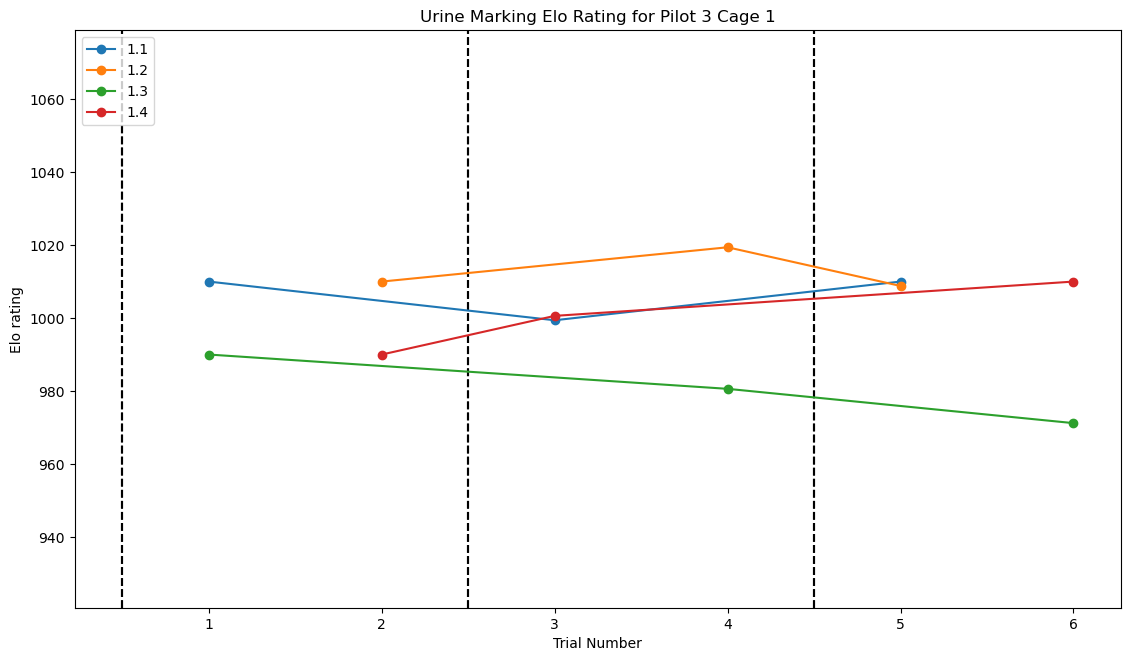

CAGE2


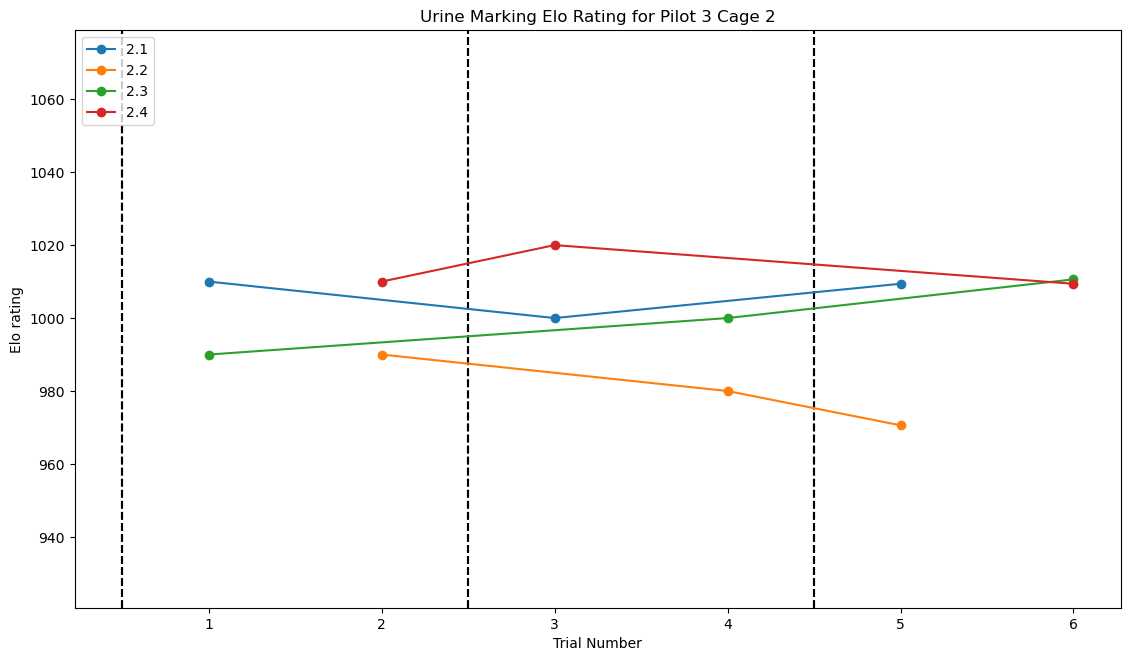

CAGE3


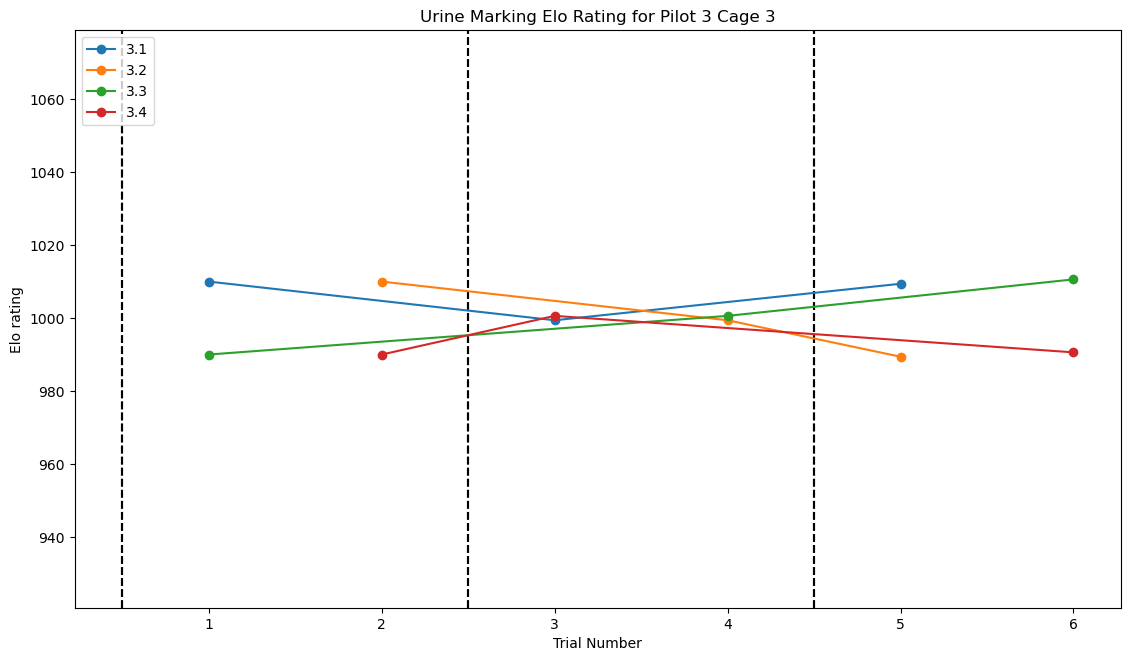

CAGE4


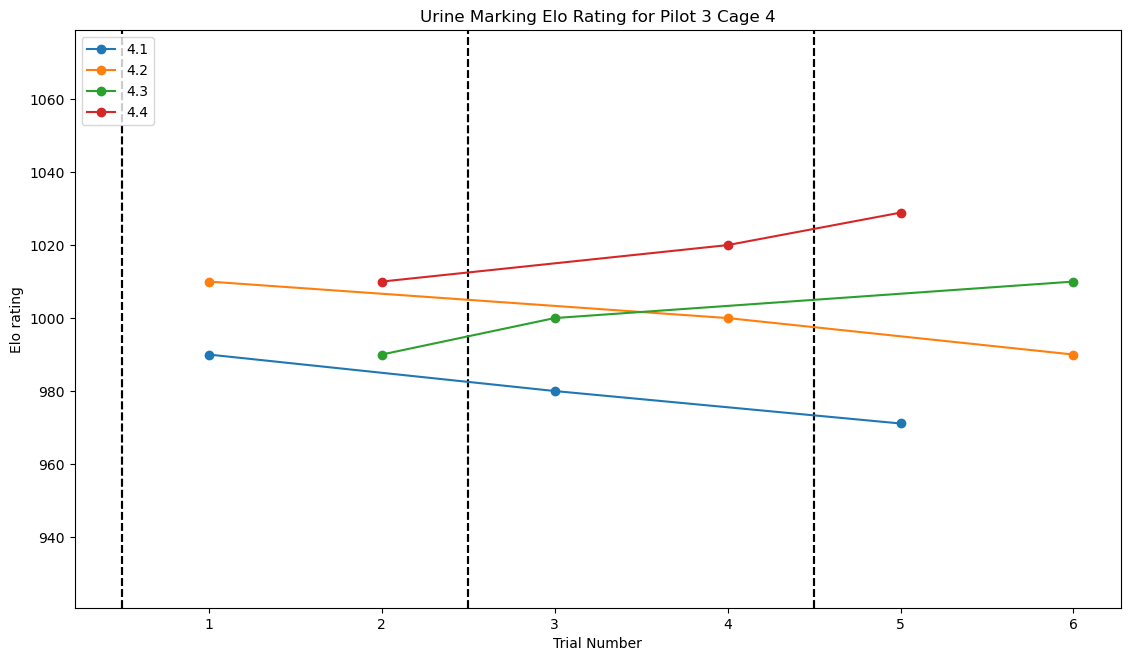

CAGE5


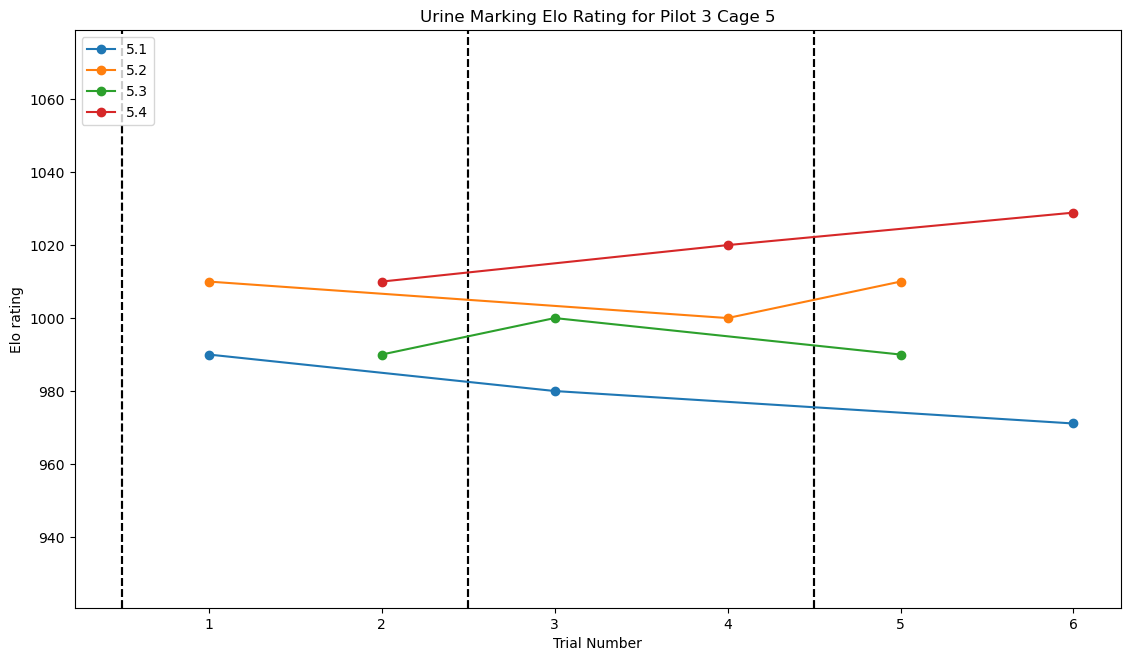

CAGE6


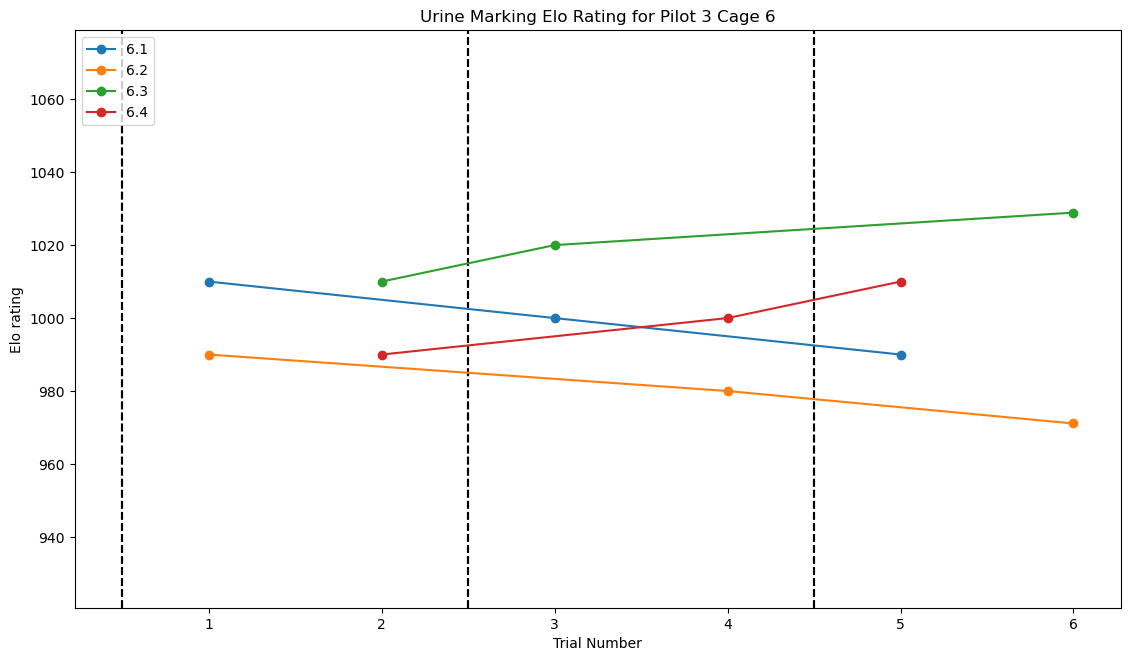

In [92]:
# Getting the highest and lowest Elo rating for cutoffs of the Y-axis
max_elo_rating = all_sheet_elo_scord_dataframe_combined["updated_elo_rating"].max()
min_elo_rating = all_sheet_elo_scord_dataframe_combined["updated_elo_rating"].min()

plt.rcParams["figure.figsize"] = (13.5,7.5)
# Making a plot for each sheet
for key, value in sheet_name_to_everything.items():
    # Setting the size of the figure
    plt.rcParams["figure.figsize"] = (13.5,7.5)
    print(key)
    elo_rating_dataframe = value["elo_rating_dataframe"]
    # Using a new figure template for each sheet
    fig, ax = plt.subplots()        
        
    try:
        # Drawing vertical lines that represent when each session begins
        # Based on when a row has a different session than the previous row
        for index, row in elo_rating_dataframe[elo_rating_dataframe['session_number_difference'].astype(bool)].iterrows():
            # Offsetting by 0.5 to avoid drawing the line on the dot
            # Drawing the lines a little above the max and a little below the minimum
            plt.vlines(x=[row["total_match_number"] - 0.5], ymin=min_elo_rating-50, ymax=max_elo_rating+50, colors='black', linestyle='dashed')
    except:
        print("WARNING: {} does not have a column for session divider".format(key))
        warnings.warn("Look at warning from above or below")
            
    # Drawing a line for each subject
    for subject in sorted(elo_rating_dataframe["subject_id"].unique()):
        # Getting all the rows with the current subject
        subject_dataframe = elo_rating_dataframe[elo_rating_dataframe["subject_id"] == subject]
        # Making the current match number the X-Axis
        plt.plot(subject_dataframe["total_match_number"], subject_dataframe["updated_elo_rating"], '-o', label=subject)

    # Labeling the X/Y Axis and the title
    ax.set_xlabel("Trial Number")
    ax.set_ylabel("Elo rating")
    # Formattnig Cohort and Experiment Name so that it's more readable with spacing and capitalization
    try:
        formatted_cohort_name = " ".join(cohort_name.split("_")).capitalize()
    except:
        formatted_cohort_name = cohort_name
    try:
        formatted_protocol_name = string.capwords(" ".join(protocol_name.split("_")))
    except:
        formatted_protocol_name = protocol_name
    try:
        formatted_cage_name = " ".join((re.match(r"([a-z]+)([0-9]+)", key, re.I).groups())).capitalize()    
    except:
        formatted_cage_name = key
    ax.set_title("{} Elo Rating for {} {}".format(formatted_protocol_name, formatted_cohort_name, formatted_cage_name))
    
    # To show the legend
    ax.legend(loc="upper left")
    # Setting the values of the Y-axis
    plt.ylim(min_elo_rating-50, max_elo_rating+50) 
    # Saving the plot
    file_name_parts_separated = [prefix_name, cohort_name, key, earliest_date, latest_date]
    file_name_parts_combined = "_".join([part for part in file_name_parts_separated if part])
    
    file_name_full = "elo_rating_{}.png".format(file_name_parts_combined)
    # Removing all the spaces and replacing them with underscores
    file_name_full = "_".join(file_name_full.split(" "))
    plt.savefig(os.path.join(plot_output_directory, file_name_full))
    # Showing the plots
    plt.show()

# Saving the Dataframes

- Creating a subfolder to put the Elo rating Spreadsheets

In [93]:
elo_rating_spreadsheet_output_directory = os.path.join(".", "proc", "elo_rating_spread_sheets", "{}".format(protocol_name))

In [94]:
elo_rating_spreadsheet_output_directory

'./proc/elo_rating_spread_sheets/urine_marking'

In [95]:
os.makedirs(elo_rating_spreadsheet_output_directory, exist_ok=True)

- Saving the dataframes to a file

In [96]:
file_name_parts_separated = [cohort_name, all_cages_string, prefix_name, earliest_date, latest_date]
file_name_parts_combined = "_".join([part for part in file_name_parts_separated if part])

file_name_full = "{}_elo-rating-history.csv".format(file_name_parts_combined)
print(file_name_full)
all_sheet_elo_scord_dataframe_combined.to_csv(os.path.join(elo_rating_spreadsheet_output_directory, file_name_full))

pilot_3_cages-1-2-3-4-5-6_uma_2022-09-12_2022-09-16_elo-rating-history.csv


In [97]:
file_name_full = "{}_final-elo-rating.csv".format(file_name_parts_combined)
print(file_name_full)
id_to_final_elo_rating_df.to_csv(os.path.join(elo_rating_spreadsheet_output_directory, file_name_full))

pilot_3_cages-1-2-3-4-5-6_uma_2022-09-12_2022-09-16_final-elo-rating.csv


# Seeing which subject is the dominant or submissive

- Grouping all the rows with the same pair

In [98]:
all_processed_behavior_recording_list = []
for key, value in sheet_name_to_everything.items():
    all_processed_behavior_recording_list.append(value["processed_behavior_recording_dataframe"])
    

- Combining all the dataframes from all the cages

In [99]:
all_processed_behavior_recording_df = pd.concat(all_processed_behavior_recording_list)

In [100]:
all_processed_behavior_recording_df.head()

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,notes,sheet_name,session_number_difference,processed_cage_num_of_winner,processed_cage_num_of_loser
0,2022-09-14,1v3,31.0,9.0,1.1,1.3,NaN,NaN,CAGE1,NaN,1,1
1,2022-09-14,2v4,8.0,70.0,1.2,1.4,NaN,NaN,CAGE1,0.0,1,1
2,2022-09-15,1v4,1.0,3.0,1.4,1.1,tie,NaN,CAGE1,1.0,1,1
3,2022-09-15,2v3,27.0,5.0,1.2,1.3,tie,NaN,CAGE1,0.0,1,1
4,2022-09-16,1vs2,1.0,1.0,1.1,1.2,tie,NaN,CAGE1,1.0,1,1


- Getting a tuple of the animal IDs to be able to group

# Note: This assumes that all the animal IDs are different across cages and that all IDs are numbers. i.e. there are no duplicate IDs in different cages.

In [101]:
# Getting the animal IDs from the Match string
# i.e. Getting all the floats and removing all spaces
# Sorting so that the animal IDs are always in the same order
all_processed_behavior_recording_df["animal_id"] =  all_processed_behavior_recording_df["match"].apply(lambda x: sorted([subject_id.lower().strip() for subject_id in re.findall(r"[-+]?(?:\d*\.\d+|\d+)", x)]))


In [102]:
# Making a tuple out of the list
# Tuples are used because lists are mutable and can't be grouped with
all_processed_behavior_recording_df["tuple_animal_id"] = all_processed_behavior_recording_df["animal_id"].apply(lambda x: tuple(x))

In [103]:
all_processed_behavior_recording_df.head()

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,notes,sheet_name,session_number_difference,processed_cage_num_of_winner,processed_cage_num_of_loser,animal_id,tuple_animal_id
0,2022-09-14,1v3,31.0,9.0,1.1,1.3,NaN,NaN,CAGE1,NaN,1,1,"[1, 3]","(1, 3)"
1,2022-09-14,2v4,8.0,70.0,1.2,1.4,NaN,NaN,CAGE1,0.0,1,1,"[2, 4]","(2, 4)"
2,2022-09-15,1v4,1.0,3.0,1.4,1.1,tie,NaN,CAGE1,1.0,1,1,"[1, 4]","(1, 4)"
3,2022-09-15,2v3,27.0,5.0,1.2,1.3,tie,NaN,CAGE1,0.0,1,1,"[2, 3]","(2, 3)"
4,2022-09-16,1vs2,1.0,1.0,1.1,1.2,tie,NaN,CAGE1,1.0,1,1,"[1, 2]","(1, 2)"


- Removing columns that would be unnecessary for the pairings

In [104]:
all_processed_behavior_recording_df.columns

Index(['date', 'match', 'left_number_of_spots', 'right_number_of_spots',
       'winner', 'loser', 'ties', 'notes', 'sheet_name',
       'session_number_difference', 'processed_cage_num_of_winner',
       'processed_cage_num_of_loser', 'animal_id', 'tuple_animal_id'],
      dtype='object')

In [105]:
# Getting only the columns that we need
all_processed_behavior_recording_df = all_processed_behavior_recording_df[['date', 'winner', 'loser', 'animal_id', 'tuple_animal_id', "processed_cage_num_of_winner", "processed_cage_num_of_loser"]]

In [106]:
all_processed_behavior_recording_df.head()

,date,winner,loser,animal_id,tuple_animal_id,processed_cage_num_of_winner,processed_cage_num_of_loser
0,2022-09-14,1.1,1.3,"[1, 3]","(1, 3)",1,1
1,2022-09-14,1.2,1.4,"[2, 4]","(2, 4)",1,1
2,2022-09-15,1.4,1.1,"[1, 4]","(1, 4)",1,1
3,2022-09-15,1.2,1.3,"[2, 3]","(2, 3)",1,1
4,2022-09-16,1.1,1.2,"[1, 2]","(1, 2)",1,1


- Getting the ID of the winner and the loser for each pair with each match

In [107]:
all_wins_per_pair = all_processed_behavior_recording_df.groupby("tuple_animal_id")['winner'].apply(list)
all_loses_per_pair = all_processed_behavior_recording_df.groupby("tuple_animal_id")['loser'].apply(list)

In [108]:
all_wins_per_pair[:5]

tuple_animal_id
(1, 2)    [1.1, 2.1, 3.1, 4.2, 5.2, 6.1]
(1, 3)    [1.1, 2.1, 3.1, 4.3, 5.3, 6.3]
(1, 4)    [1.4, 2.4, 3.4, 4.4, 5.4, 6.4]
(2, 3)    [1.2, 2.3, 3.3, 4.3, 5.2, 6.3]
(2, 4)    [1.2, 2.4, 3.2, 4.4, 5.4, 6.4]
Name: winner, dtype: object

- Making a dataframe of all the winner IDs and all the loser IDs for a given pair

In [109]:
all_competition_per_pair_df = pd.concat([all_wins_per_pair, all_loses_per_pair], axis=1).reset_index()

In [110]:
all_competition_per_pair_df = all_competition_per_pair_df.rename(columns={k: prefix_name + "_" + k for k in all_competition_per_pair_df.columns})

In [111]:
all_competition_per_pair_df

,uma_tuple_animal_id,uma_winner,uma_loser
0,"(1, 2)","[1.1, 2.1, 3.1, 4.2, 5.2, 6.1]","[1.2, 2.2, 3.2, 4.1, 5.1, 6.2]"
1,"(1, 3)","[1.1, 2.1, 3.1, 4.3, 5.3, 6.3]","[1.3, 2.3, 3.3, 4.1, 5.1, 6.1]"
2,"(1, 4)","[1.4, 2.4, 3.4, 4.4, 5.4, 6.4]","[1.1, 2.1, 3.1, 4.1, 5.1, 6.1]"
3,"(2, 3)","[1.2, 2.3, 3.3, 4.3, 5.2, 6.3]","[1.3, 2.2, 3.2, 4.2, 5.3, 6.2]"
4,"(2, 4)","[1.2, 2.4, 3.2, 4.4, 5.4, 6.4]","[1.4, 2.2, 3.4, 4.2, 5.2, 6.2]"
5,"(3, 4)","[1.4, 2.3, 3.3, 4.4, 5.4, 6.3]","[1.3, 2.4, 3.4, 4.3, 5.3, 6.4]"


- Adding the cage information

In [112]:
# Getting the cage number for each pair
dropped_duplicate_all_processed_behavior_recording_df = all_processed_behavior_recording_df[["tuple_animal_id"]].drop_duplicates()

In [113]:
dropped_duplicate_all_processed_behavior_recording_df.head()

,tuple_animal_id
0,"(1, 3)"
1,"(2, 4)"
2,"(1, 4)"
3,"(2, 3)"
4,"(1, 2)"


- Calculating the overall winner and loser. Also seeing if there is signficant difference in the number of wins to see if one is dominant over the other

In [114]:
all_competition_per_pair_df["cohort"] = cohort_name


In [115]:
all_competition_per_pair_df["{}_averaged_winner".format(prefix_name)] = all_competition_per_pair_df["{}_winner".format(prefix_name)].apply(lambda x: Counter(x).most_common(1)[0][0])
all_competition_per_pair_df["{}_averaged_loser".format(prefix_name)] = all_competition_per_pair_df["{}_loser".format(prefix_name)].apply(lambda x: Counter(x).most_common(1)[0][0])
all_competition_per_pair_df["{}_winner_count".format(prefix_name)] = all_competition_per_pair_df.apply(lambda x: x["{}_winner".format(prefix_name)].count(x["{}_averaged_winner".format(prefix_name)]), axis=1)
all_competition_per_pair_df["{}_loser_count".format(prefix_name)] = all_competition_per_pair_df.apply(lambda x: x["{}_winner".format(prefix_name)].count(x["{}_averaged_loser".format(prefix_name)]), axis=1)
all_competition_per_pair_df["{}_count_difference".format(prefix_name)] = all_competition_per_pair_df["{}_winner_count".format(prefix_name)] - all_competition_per_pair_df["{}_loser_count".format(prefix_name)]
all_competition_per_pair_df["{}_match_count".format(prefix_name)] = all_competition_per_pair_df["{}_winner".format(prefix_name)].apply(lambda x: len(x))
all_competition_per_pair_df["{}_percent_win".format(prefix_name)] = all_competition_per_pair_df.apply(lambda x: x["{}_winner_count".format(prefix_name)] / x["{}_match_count".format(prefix_name)], axis=1)
all_competition_per_pair_df["{}_percentage_tie".format(prefix_name)] = all_competition_per_pair_df["{}_percent_win".format(prefix_name)].apply(lambda x: True if x < 0.75 else False)

In [116]:
all_competition_per_pair_df

,uma_tuple_animal_id,uma_winner,uma_loser,cohort,uma_averaged_winner,uma_averaged_loser,uma_winner_count,uma_loser_count,uma_count_difference,uma_match_count,uma_percent_win,uma_percentage_tie
0,"(1, 2)","[1.1, 2.1, 3.1, 4.2, 5.2, 6.1]","[1.2, 2.2, 3.2, 4.1, 5.1, 6.2]",pilot_3,1.1,1.2,1,0,1,6,0.166667,True
1,"(1, 3)","[1.1, 2.1, 3.1, 4.3, 5.3, 6.3]","[1.3, 2.3, 3.3, 4.1, 5.1, 6.1]",pilot_3,1.1,1.3,1,0,1,6,0.166667,True
2,"(1, 4)","[1.4, 2.4, 3.4, 4.4, 5.4, 6.4]","[1.1, 2.1, 3.1, 4.1, 5.1, 6.1]",pilot_3,1.4,1.1,1,0,1,6,0.166667,True
3,"(2, 3)","[1.2, 2.3, 3.3, 4.3, 5.2, 6.3]","[1.3, 2.2, 3.2, 4.2, 5.3, 6.2]",pilot_3,1.2,1.3,1,0,1,6,0.166667,True
4,"(2, 4)","[1.2, 2.4, 3.2, 4.4, 5.4, 6.4]","[1.4, 2.2, 3.4, 4.2, 5.2, 6.2]",pilot_3,1.2,1.4,1,0,1,6,0.166667,True
5,"(3, 4)","[1.4, 2.3, 3.3, 4.4, 5.4, 6.3]","[1.3, 2.4, 3.4, 4.3, 5.3, 6.4]",pilot_3,1.4,1.3,1,0,1,6,0.166667,True


- Saving the competiton pair results dataframe to a file

In [117]:
file_name = "{}_{}_grouped_by_pairs_cage_{}_date_{}_{}.csv".format(cohort_name, prefix_name, all_cages_string, earliest_date, latest_date)


In [118]:
elo_rating_spreadsheet_output_directory

'./proc/elo_rating_spread_sheets/urine_marking'

In [119]:
file_name

'pilot_3_uma_grouped_by_pairs_cage_cages-1-2-3-4-5-6_date_2022-09-12_2022-09-16.csv'

In [120]:
all_competition_per_pair_df.to_csv(os.path.join(elo_rating_spreadsheet_output_directory, file_name))